# ECG Modeling



# load DataFrames


In [ ]:
#  Load ecg_train_df and ecg_test_df

import pandas as pd


try:
    train_df = pd.read_csv('ecg_train.csv')
    test_df = pd.read_csv('ecg_test.csv')
    print("DataFrames loaded successfully.")
except FileNotFoundError:
    print("Error: One or both of the CSV files were not found. Please check the filenames and ensure they are in the current working directory.")
except pd.errors.ParserError:
    print("Error: Could not parse the CSV files.  Please check their format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


As we know, the ECG dataset is highly imbalanced.

So, in my initial experiment,

I tried to handle this issue using data augmentation and class weights.

##  Data Augmentation
Data augmentation is a technique used to increase the size of the training dataset by applying random transformations to the images. This helps to improve the model's ability to generalize and reduce overfitting. We will apply the following augmentations to the training data:

- *Rotation*: Rotate images to simulate different orientations.
- *Width and Height Shift*: Randomly shift the image along width and height to make the model more robust.
- *Zoom*: Zoom in on the image to simulate scale variation.
- *Flip*: Flip the image horizontally or vertically.
- *Brightness*: Adjust brightness randomly to simulate lighting changes.

These augmentations will help increase the diversity of the dataset and improve model accuracy on unseen data.

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_df,val_df = train_test_split(train_df,test_size=0.2,random_state=42,stratify=train_df['label'])
# Create the data generators for train, validation, and test
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



    # Create train and validation generators
train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle = True
    )

val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    # Create a test generator (using the test dataframe, assuming you have one)
test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    # Now you can train your model with train_generator and validate with val_generator

Found 79359 validated image filenames belonging to 6 classes.
Found 19840 validated image filenames belonging to 6 classes.
Found 24799 validated image filenames belonging to 6 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

#Compute class weights for handling imbalanced data y_train = train_df['label'].values class_weights = class_weight.compute_class_weight( class_weight='balanced', classes=np.unique(y_train), y=y_train ) class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

#Load the VGG16 model pre-trained on ImageNet, without the top layer (to modify for our problem)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freeze the layers of VGG16 to retain its learned features
for layer in base_model.layers:
    layer.trainable = False

#Create the model by adding custom layers on top of VGG16
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax')) # 6 classes (change as needed)
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,781,126 (56.39 MB)

 Trainable params: 66,438 (259.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

#Compute class weights for handling imbalanced data y_train = train_df['label'].values class_weights = class_weight.compute_class_weight( class_weight='balanced', classes=np.unique(y_train), y=y_train ) class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

#Load the VGG16 model pre-trained on ImageNet, without the top layer (to modify for our problem)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freeze the layers of VGG16 to retain its learned features
for layer in base_model.layers:
    layer.trainable = False

#Create the model by adding custom layers on top of VGG16
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax')) # 6 classes (change as needed)
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,781,126 (56.39 MB)

 Trainable params: 66,438 (259.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Compute class weights for handling imbalanced data
y_train = train_df['label'].values
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {cls:weight for cls, weight in zip(np.unique(y_train),class_weights)}

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','recall'])

In [ ]:
history = model.fit(train_generator,
                    epochs=15, validation_data=val_generator,
                    callbacks=[early_stopping,reduce_lr,checkpoint],
                       class_weight=class_weight_dict)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2480/2480 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9107 - loss: 0.2967 - recall: 0.8832
Epoch 1: val_accuracy improved from -inf to 0.99904, saving model to CovidModelEfficientNet.keras
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 608s 239ms/step - accuracy: 0.9107 - loss: 0.2966 - recall: 0.8832 - val_accuracy: 0.9990 - val_loss: 0.0088 - val_recall: 0.9988 - learning_rate: 0.0010
Epoch 2/15
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9974 - loss: 0.0147 - recall: 0.9965
Epoch 2: val_accuracy improved from 0.99904 to 0.99985, saving model to CovidModelEfficientNet.keras
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 419s 169ms/step - accuracy: 0.9974 - loss: 0.0147 - recall: 0.9965 - val_accuracy: 0.9998 - val_loss: 0.0013 - val_recall: 0.9998 - learning_rate: 0.0010
Epoch 3/15
2480/2480 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9989 - loss: 0.0061 - recall: 0.9988
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 3: val_accuracy improved from 0.99985 

775/775 ━━━━━━━━━━━━━━━━━━━━ 206s 266ms/step - accuracy: 0.9999 - loss: 1.8316e-04 - recall: 0.9999
Test Loss: 0.00024904432939365506
Test Accuracy: 0.9999193549156189
Test Recall: 0.9999193549156189


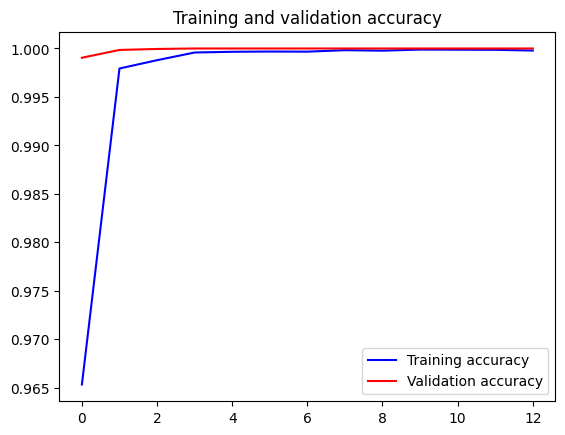

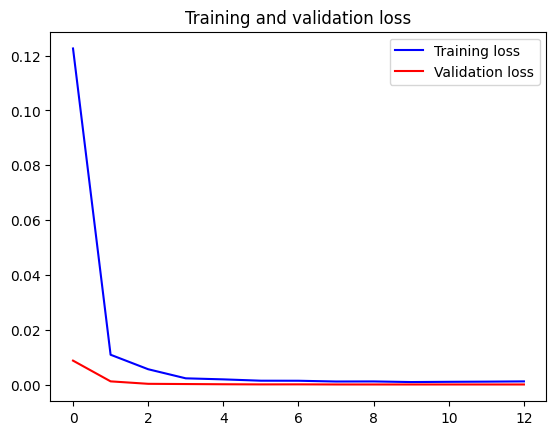

In [ ]:
#  evaluate the model

import matplotlib.pyplot as plt
# Evaluate the model on the test set
loss, accuracy, recall = model.evaluate(test_generator)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Recall: {recall}")

# Plot the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Predict on the test set

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

The initial classification report revealed poor performance

,with accuracy,precision, and recall falling below 50% for all classes except the majority class, suggesting significant overfitting.


 To address this, I plan to revise my approach by applying downsampling to the majority class and undersampling the remaining classes."


At the beginning, the model showed a high accuracy of 95% on the training set and only 5% on the validation set during the first two epochs, which was a clear sign of overfitting.

 In response, I reduced the number of layers in the model, increased the dropout layers to prevent overfitting, added a BatchNormalization layer to improve generalization, and applied data augmentation techniques to enhance the model's robustness."


In [ ]:
from sklearn.utils import resample
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load train_df and test_df (assuming you have them from before)
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_df,val_df = train_test_split(train_df,test_size=0.2,random_state=42,stratify=train_df['label'])
# 1. Under-sample the N class to 8000
n_class = train_df[train_df['label'] == 'N']
other_classes = train_df[train_df['label'] != 'N']

n_class_undersampled = resample(n_class,
                                replace=False,  # Don't allow replacement
                                n_samples=8000,  # Downsample to 8000
                                random_state=42)
# 2. Over-sample other classes to 8000 (for balancing)
oversampled_classes = []
for label in other_classes['label'].unique():
    class_data = other_classes[other_classes['label'] == label]
    class_data_oversampled = resample(class_data,
                                      replace=True,  # Allow replacement for oversampling
                                      n_samples=8000,  # Up-sample to 8000
                                      random_state=42)
    oversampled_classes.append(class_data_oversampled)

# 3. Combine all classes (undersampled N and oversampled others)
balanced_train_df = pd.concat([n_class_undersampled] + oversampled_classes)

# Shuffle the combined data
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Now create the ImageDataGenerators for train, validation, and test
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 40,
                                   width_shift_range =0.2,
                                   height_shift_range = 0.2,
                                   shear_range =0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                            fill_mode = 'nearest'
                              )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(  balanced_train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
val_generator = test_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)


test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',shuffle =False
)


Found 48000 validated image filenames belonging to 6 classes.
Found 19840 validated image filenames belonging to 6 classes.
Found 24799 validated image filenames belonging to 6 classes.


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Load the VGG16 model pre-trained on ImageNet, without the top layer (to modify for our problem)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some of the top layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Create the model by adding custom layers on top of VGG16
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())  # Add BatchNormalization layer
model.add(layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))

model.add(layers.Dropout(0.6))  # Dropout layer for regularization
#model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
#model.add(layers.Dropout(0.3))  # Another Dropout layer
model.add(layers.Dense(6, activation='softmax'))  # 6 classes (update if needed)
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
optimizer=Adam(learning_rate =0.00001)
# Compile the model
model.compile(optimizer =optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'recall'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,749,958 (56.27 MB)

 Trainable params: 14,748,934 (56.26 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.9759 - loss: 0.8160 - recall: 0.9673
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 958s 610ms/step - accuracy: 0.9759 - loss: 0.8157 - recall: 0.9673 - val_accuracy: 1.0000 - val_loss: 0.0697 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9999 - loss: 0.0489 - recall: 0.9998
Epoch 2: val_accuracy did not improve from 1.00000
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 865s 575ms/step - accuracy: 0.9999 - loss: 0.0489 - recall: 0.9998 - val_accuracy: 1.0000 - val_loss: 0.0123 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9982 - loss: 0.0271 - recall: 0.9973
Epoch 3: val_accuracy did not improve from 1.00000
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 851s 565ms/step - accuracy: 0.9982 - loss: 0.0271 - recall: 0.9973 - val_accuracy: 1.0000 - v

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Predict on the test set

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


775/775 ━━━━━━━━━━━━━━━━━━━━ 236s 304ms/step
              precision    recall  f1-score   support

           F       1.00      1.00      1.00       161
           M       1.00      1.00      1.00      2101
           N       1.00      1.00      1.00     18926
           Q       1.00      1.00      1.00      1608
           S       1.00      1.00      1.00       556
           V       1.00      1.00      1.00      1447

    accuracy                           1.00     24799
   macro avg       1.00      1.00      1.00     24799
weighted avg       1.00      1.00      1.00     24799



**This is a great result ,so I will save this model**

In [ ]:
model.save('my_ecg_model.h5')

In [ ]:
print(train_generator.class_indices)

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os

# Load trained model
model = tf.keras.models.load_model("/kaggle/working/my_ecg_model.h5")

# Define class labels
class_labels = ['F', 'M', 'N', 'Q', 'S', 'V']
# Load and preprocess the image
img_path = "/kaggle/input/ecg-image-data/ECG_Image_data/test/F/F0.png"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict the class
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_class = class_labels[predicted_class_index]

# Get actual class from folder name in path
actual_class = os.path.basename(os.path.dirname(img_path)).upper()

# Diagnostic description
descriptions = {
    "N": "Normal Beat – The heart rhythm appears within normal limits.",
    "F": "Fusion of paced and normal beat – A hybrid beat, usually seen in patients with pacemakers.",
    "S": "Supraventricular – Indicates beats originating above the ventricles, e.g., atrial fibrillation.",
    "Q": "Unknown Beat – Irregular beat that doesn't match common arrhythmias.",
    "V": "Premature Ventricular Contraction (PVC) – A wide QRS complex indicating early ventricular activation.",
    "M": "Fusion of ventricular and normal beat – Simultaneous activation from two different pacemakers."
}
print("\n--- ECG Diagnostic Report ---\n")
print(f"Image Path: {img_path}")
print(f"Predicted Class: {predicted_class} – {descriptions[predicted_class]}")
print(f"Actual Class from Path: {actual_class} – {descriptions.get(actual_class, 'Unknown')}")

if predicted_class != actual_class:
    print("\n[!] Warning: Prediction does not match actual label.")
    print("    This may be due to image ambiguity or class imbalance.")
    print("    Consider visual review or more training examples.\n")
else:
    print("\n[✓] Model prediction matches the actual label.\n")

print("--- End of Report ---")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step

--- ECG Diagnostic Report ---

Image Path: /kaggle/input/ecg-image-data/ECG_Image_data/test/F/F0.png
Predicted Class: F – Fusion of paced and normal beat – A hybrid beat, usually seen in patients with pacemakers.
Actual Class from Path: F – Fusion of paced and normal beat – A hybrid beat, usually seen in patients with pacemakers.

[✓] Model prediction matches the actual label.

--- End of Report ---
